## Here we get expression level of interested genes from internal and public datasets

In [1]:
import pandas as pd
import math
import re, os
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

### First We define gene names and build {geneid:genename} dictionary

In [2]:
# define interested genes
interest_genes = ['Cdk9', 'Cdk12', 'Supt4h1', 'Supt5h', 'Elof1', 'Tcea2', 'Brca1', 
                  'Bard1', 'EloA', 'parp1', 'Supt16H', 'Ercc6', 'Ercc5', 'Crebbp', 
                  'Ep300', 'Hmgb1', 'Smarcad1', 'Setx', 'Dhx9']
interest_genes = [g.upper() for g in interest_genes]

In [3]:
# 1. get gene id and name mapping for human and build id to name dictionary
gff = '/home/lis262/Downloads/human_v30.gff'
map_fn = '/hpc/grid/hgcb/workspace/users/shangzhong/RE/HD/human_gene_id_name_map.txt'

In [4]:
def get_human_gene_id_name_map(gff, id_fn):
    '''this function parse the gff file and create a {genename: geneid} dictionary
    * gff: input file
    * id_fn: id mapping file. has 2 columns. '''
    if not os.path.exists(id_fn):
        id_df = pd.read_csv(fn, sep='\t',comment='#',header=None)
        id_df = id_df[id_df[2].values=='gene']
        id_df = id_df.reset_index(drop=True)
        id_df['id'] = id_df[8].map(lambda x: re.search('(?<=ID=).+?(?=\.)', x).group(0))
        id_df['name'] = id_df[8].map(lambda x: re.search('(?<=gene_name=).+?(?=;)', x).group(0))
        id_df[['id','name']].to_csv(map_fn, sep='\t', index=False)
    else:
        id_df = pd.read_csv(id_fn, sep='\t',header=0)

    id2name_dic = id_df.set_index('id')['name'].to_dict()
    return id2name_dic
id2name_dic = get_human_gene_id_name_map(gff, map_fn)

In [ ]:
# # define interested genes
# interest_genes = ['CDK9', 'CDK12', 'SUPT4H1', 'SUPT5H', 'ELOF1', 'TCEA2', 'BRCA1', \
#                   'BARD1', 'ELOA', 'PARP1', 'SUPT16H', 'ERCC6', 'ERCC5', 'CREBBP', \
#                   'EP300', 'HMGB1', 'SMARCAD1', 'SETX', 'DHX9']

In [161]:
# BER genes
interest_genes = ['UNG', 'SMUG1', 'MBD4', 'TDG','OGG1', 'MUTYH', 'NTHL1',
                 'MPG', 'NEIL1', 'NEIL2','NEIL3']

# # NER genes
# interest_genes = ['XPC', 'RAD23B', 'CETN2', 'RAD23A', 'XPA', 'DDB1', 'DDB2',
#                  'RPA1', 'RPA2', 'RPA3', 'ERCC3','ERCC2','GTF2H1','GTF2H2',
#                  'GTF2H3','GTF2H4', 'GTF2H5','CDK7','CCNH','MNAT1','ERCC5',
#                  'ERCC1','ERCC4','LIG1','ERCC8','ERCC6','UVSSA','XAB2','MMS19']

### Process LIBER data sets. 
This datasets has 4 phenotypes: control, Biopolar, MDD(major depressive disorder), schizophrenia. There are mainly two races: caucasian and afrian america. Michael Nagle has done quantification for these samples. The procedure is as follows: 1. align reads to the genome. 2. count the reads. 3. transfer the count to tpm.
The procedure for this code is to use the tpm expression matrix as input, then combine it with the clinical information to plot the expression level for those genes we are interested that could be potential targets for repeat expansion.

Here we build a dataframe, the format is as follows: 1st column is sample ids, 2nd column is phenotype, the rest of the columns are tpm of interested genes. Then for each gene we can do a boxplot grouped by phenotype.

In [163]:
def liber_build_interested_genes_tpm_df(tpm_fn, clinical_fn, genes, id2name_dic, race):
    '''this function builds the tpm dataframe of interested genes
    * genes: a list of gene names
    * id2name_dic: dictionary of {geneid: genename}
    '''
    meta_df = pd.read_csv(clinical_fn, sep='\t')
    meta_df['BrNum'] = meta_df['BrNum'].map(lambda x: 'Br' + str(x))
    #-------- original # of samples
    # meta_df['Race'].value_counts()
    #-------- extract expression of interested genes, replace geneid with gene name
    tpm_df = pd.read_csv(tpm_fn, sep='\t',header=0,index_col=0,low_memory=False)
    # add gene gene
    tpm_df['name'] = tpm_df.index.map(lambda x: id2name_dic[x].upper() if x in id2name_dic else x)
    int_tpm_df = tpm_df[tpm_df['name'].isin(genes)]
    int_tpm_df.index = int_tpm_df['name']
    del int_tpm_df['name']
    #------- extract interested samples' clinical information
    int_samples = int_tpm_df.columns.tolist()
    int_meta_df = meta_df.query('Race == @race and BrNum in @int_samples')
    int_meta_df = int_meta_df.reset_index(drop=True)
    int_sample_dic = {k:list(v) for k,v in int_meta_df.groupby('DxGroup')['BrNum']} # {phenotype:[samples]}
    # build dataframe, the first column is samples id, the 2nd is phenotype, the others are genes.
    # values are tpm for each gene
    g_df = int_meta_df[['BrNum','DxGroup']]
    g_df = g_df.reset_index(drop=True)
    print(g_df['DxGroup'].value_counts())
    for g in genes:
        brnum_tpm_dic = int_tpm_df.loc[g,:].to_dict()
        g_df[g] = g_df['BrNum'].map(lambda x: brnum_tpm_dic[x] if x in brnum_tpm_dic else None)
    return g_df, int_sample_dic, int_tpm_df

In [164]:
cauc_tpm_fn = '/home/lis262/Downloads/TPM_counts_CAUC.tsv'
aa_tpm_fn = '/home/lis262/Downloads/TPM_counts_AA.tsv'
clinical_fn = '/home/lis262/Downloads/LIBD_DemographicClinicalData_746.csv'
print('process caucation samples')
cauc_tpm_df, cauc_sample_dic, cauc_pivot_df = liber_build_interested_genes_tpm_df(cauc_tpm_fn, clinical_fn, interest_genes, id2name_dic, 'CAUC')
print('process african american samples')
aa_tpm_df, aa_sample_dic, aa_pivot_df = liber_build_interested_genes_tpm_df(aa_tpm_fn, clinical_fn, interest_genes, id2name_dic, 'AA')
#  merge the tpm of CAUC and AA
liber_int_tpm_df = cauc_tpm_df.append(aa_tpm_df)
liber_int_pivot_df = pd.concat([cauc_pivot_df, aa_pivot_df], axis=1)

process caucation samples
MDD        122
Schizo      86
Control     80
Bipolar     54
Name: DxGroup, dtype: int64
process african american samples
Control    96
Schizo     76
MDD        13
Bipolar     5
Name: DxGroup, dtype: int64


In [165]:
# get median tpm for each gene
liber_sample_dic = {**cauc_sample_dic, **aa_sample_dic}
keys = liber_sample_dic.keys()
for k in keys:
    liber_int_pivot_df[k] = liber_int_pivot_df[liber_sample_dic[k]].median(axis=1)

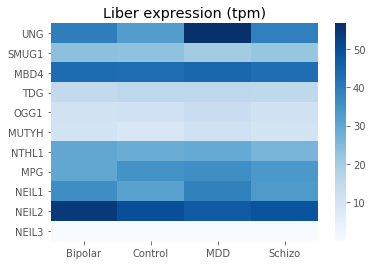

In [166]:
ax = sns.heatmap(liber_int_pivot_df.loc[interest_genes, keys], cmap='Blues')
_ = ax.set_title('Liber expression (tpm)')
_ = ax.set_ylabel('')

In [167]:
def box_plot(columns, figsize, df, interest_genes, pheno):
    '''
    * columns: in the plot how many in each row.
    * pheno: name of phenotype column indicate if it's disease or not.
    '''
    columns = 3
    rows = math.ceil(len(interest_genes))
    i = 0
    # fig = plt.figure()
    axes = []
    fig = plt.figure(figsize=(10, 80))
    for g in interest_genes:
        i += 1
        ax_i = fig.add_subplot(rows, columns, i)
        g_df = df[[pheno,g]]

        ax = g_df.boxplot(by=pheno,grid=True, ax=ax_i)
        figs = ax.get_figure()
        figs.suptitle('')
        ax.set_title(g)
        ax.set_xlabel('')
        if i % 3 == 1:
            ax.set_ylabel('tpm')

In [168]:
# box_plot(3, (10, 80), liber_int_tpm_df, interest_genes, 'DxGroup')

In [169]:
# # save figure results
# for g in interest_genes:
#     i += 1
#     g_df = liber_int_tpm_df[['DxGroup',g]]
    
#     ax = g_df.boxplot(by='DxGroup',grid=True)
#     figs = ax.get_figure()
#     figs.suptitle('')
#     ax.set_title(g + ' (LIBER)')
#     ax.set_xlabel('')
#     ax.set_ylabel('tpm')
#     plt.savefig('/home/lis262/RE/LIBER/'+ g + '.png')

### Process AMP-AD datasets
This datasets has two major subsets: cerebellum and cortex

In [170]:
def build_myo_tpm_df(clinical_fn, tpm_fn, id2name_dic, genes):
    '''this function builds the tpm dataframe of interested genes
    * genes: a list of gene names
    * id2name_dic: dictionary of {geneid: genename}
    '''
    clinical_df = pd.read_csv(clinical_fn, sep='\t')
    tpm_df = pd.read_csv(tpm_fn, sep='\t', index_col=0)
    del tpm_df['meanTpm']
    tpm_df.index = tpm_df.index.map(lambda x: id2name_dic[x] if x in id2name_dic else x)
    samples = tpm_df.columns.tolist()
    try:
        clinical_df['sample'] = clinical_df['SampleID'].map(lambda x: \
                        x.split('_')[1] + '_' + x.split('_')[0])
    except:
        clinical_df['sample'] = clinical_df['ID'].map(lambda x: \
                        x.split('_')[1] + '_' + x.split('_')[0])
    clinical_df = clinical_df.query('sample in @samples')
    clinical_df = clinical_df.reset_index(drop=True)
    sample_dic = {k:list(v) for k,v in clinical_df.groupby('Diagnosis')['sample']} # {phenotype:[samples]}
    print(clinical_df['Diagnosis'].value_counts())
    g_df = clinical_df[['sample','Diagnosis']]
    g_df = g_df.reset_index(drop=True)
    for g in genes:
        tpm_dic = tpm_df.loc[g,:].to_dict()
        g_df.loc[:,g] = g_df.loc[:,'sample'].map(lambda x: tpm_dic[x])
    return g_df, sample_dic, tpm_df

In [171]:
cerebellum_fn = '/hpc/grid/hgcb/workspace/projects/P021_MAYO_Banner_RNAseq/cerebellum/genetic_omic_data/salmon_quants/MAYO_cerebellum_group.ID_adj_lane_RIN_Gender_age_rmRIN6.5_salmon_TPM_matrix_gene_level_summarized.txt'
cerebellum_clinical_fn = '/hpc/grid/hgcb/workspace/projects/P021_MAYO_Banner_RNAseq/cerebellum/clinical_data/MayoRNAseq_RNAseq_CBE_covariates_updatedMay2017.csv'
cerebellum_tpm_df, cerebellum_sample_dic, cerebellum_pivot_df = \
                   build_myo_tpm_df(cerebellum_clinical_fn, cerebellum_fn, id2name_dic, interest_genes)

AD         76
Control    67
Name: Diagnosis, dtype: int64


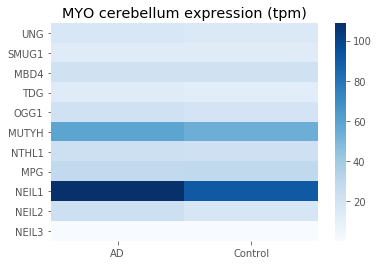

In [172]:
for k, v in cerebellum_sample_dic.items():
    cerebellum_pivot_df[k] = cerebellum_pivot_df[v].median(axis=1)
ax = sns.heatmap(cerebellum_pivot_df.loc[interest_genes, cerebellum_sample_dic.keys()], cmap='Blues')
_ = ax.set_title('MYO cerebellum expression (tpm)')
_ = ax.set_ylabel('')

In [173]:
# for g in interest_genes:
#     g_df = cerebellum_tpm_df[['Diagnosis',g]]
    
#     ax = g_df.boxplot(by='Diagnosis',grid=True)
#     figs = ax.get_figure()
#     figs.suptitle('')
#     ax.set_title(g + ' (MYO Cerebellum)')
#     ax.set_xlabel('')
#     ax.set_ylabel('tpm')
#     plt.savefig('/home/lis262/RE/MYO_Cerebellum/'+ g + '.png')

In [174]:
cortex_fn = '/hpc/grid/hgcb/workspace/projects/P021_MAYO_Banner_RNAseq/temporal_cortex/genetic_omic_data/salmon_quants/MAYO_tempCort_group.ID_adj_lane_RIN_Gender_age_rmRIN7.5_salmon_TPM_matrix_gene_level_summarized.txt'
cortex_clinical_fn = '/hpc/grid/hgcb/workspace/projects/P021_MAYO_Banner_RNAseq/temporal_cortex/clinical_data/MayoRNAseq_RNAseq_TCX_covariates_updatedMay2017.csv'
cortex_tpm_df, cortex_sample_dic, cortex_pivot_df = build_myo_tpm_df(cortex_clinical_fn, cortex_fn, id2name_dic, interest_genes)

AD         78
Control    41
Name: Diagnosis, dtype: int64


In [175]:
# for g in interest_genes:
#     g_df = cortex_tpm_df[['Diagnosis',g]]
    
#     ax = g_df.boxplot(by='Diagnosis',grid=True)
#     figs = ax.get_figure()
#     figs.suptitle('')
#     ax.set_title(g + ' (MYO Cortex)')
#     ax.set_xlabel('')
#     ax.set_ylabel('tpm')
#     plt.savefig('/home/lis262/RE/MYO_Cortex/'+ g + '.png')

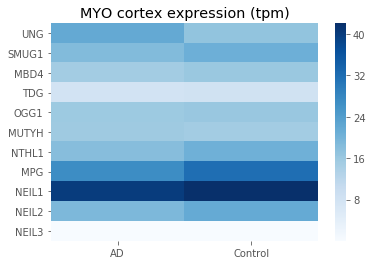

In [176]:
for k, v in cortex_sample_dic.items():
    cortex_pivot_df[k] = cortex_pivot_df[v].median(axis=1)
ax = sns.heatmap(cortex_pivot_df.loc[interest_genes, cortex_sample_dic.keys()], cmap='Blues')
_ = ax.set_title('MYO cortex expression (tpm)')
_ = ax.set_ylabel('')

In [177]:
# # plots for the cerebellum samples
# box_plot(3, (10,80), cerebellum_tpm_df, interest_genes, 'Diagnosis')

In [178]:
# # plot for the cortex data
# box_plot(3, (10,80), cortex_tpm_df, interest_genes, 'Diagnosis')

### Next, we analyze the GTEx datasets
First plot the median tpm values

In [179]:
gtx_tpm_med_fn = '/home/lis262/RE/GTeX/GTEx_tpm_median.txt'
gtx_tpm_med_df = pd.read_csv(gtx_tpm_med_fn, sep='\t', skiprows=[0,1], index_col=0)

In [180]:
# extract tissues
tissue = gtx_tpm_med_df.columns.tolist()
tissue = [t for t in tissue if 'Brain' in t or 'Liver' in t]
gtx_tpm_med_df = gtx_tpm_med_df[tissue]
# change index name
gtx_tpm_med_df.index = gtx_tpm_med_df.index.map(lambda x: x.split('.')[0])
gtx_tpm_med_df.index = gtx_tpm_med_df.index.map(lambda x: id2name_dic[x] if x in id2name_dic else x)
# extract expression for interested genes
int_gtx_tpm_med_df = gtx_tpm_med_df.loc[interest_genes,:]

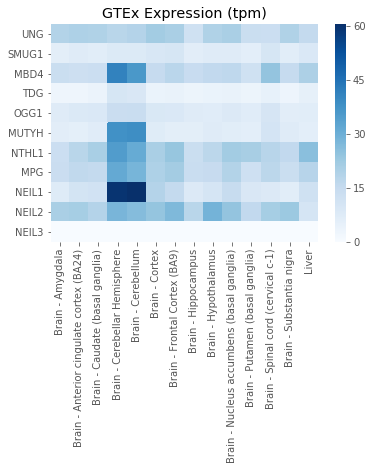

In [181]:
ax = sns.heatmap(int_gtx_tpm_med_df, cmap='Blues')
_ = ax.set_title('GTEx Expression (tpm)')
_ = ax.set_ylabel('')

### Next we analyze Huntington's Disease ArrayExpress data

In [182]:
def build_HD_BA9_tpm_df(clinical_fn, tpm_fn, id2name_dic, genes):
    '''this function builds the tpm dataframe of interested genes
    * genes: a list of gene names
    * id2name_dic: dictionary of {geneid: genename}
    '''
    clinical_df = pd.read_csv(clinical_fn, sep='\t')
    tpm_df = pd.read_csv(tpm_fn, sep='\t', index_col=0)
    tpm_df.index = tpm_df.index.map(lambda x: x.split('.')[0])
    tpm_df.index = tpm_df.index.map(lambda x: id2name_dic[x] if x in id2name_dic else x)
    samples = tpm_df.columns.tolist()
    clinical_df.rename(columns={'Comment [Sample_title]': 'sample'}, inplace=True)
    clinical_df['Diagnosis'] = clinical_df['sample'].map(lambda x: \
                    'HD' if x[0]=='H' else 'Control')
    sample_dic = {k:list(v) for k,v in clinical_df.groupby('Diagnosis')['sample']} # {phenotype:[samples]}
    print(clinical_df['Diagnosis'].value_counts())
    g_df = clinical_df[['sample','Diagnosis']]
    g_df = g_df.reset_index(drop=True)
    for g in genes:
        try:
            tpm_dic = tpm_df.loc[g,:].to_dict()
            g_df[g] = g_df['sample'].map(lambda x: tpm_dic[x])
        except:
            continue
    return g_df, sample_dic, tpm_df

In [183]:
hd_meta_fn = '/home/lis262/RE/HD_BA9/E-GEOD-64810.sdrf.txt'
hd_nm_ct_fn = '/home/lis262/RE/HD_BA9/GSE64810_mlhd_DESeq2_norm_counts_adjust.txt'
hd_nm_df, hd_sample_dic, hd_pivot_df = build_HD_BA9_tpm_df(hd_meta_fn, hd_nm_ct_fn, id2name_dic, interest_genes)

Control    49
HD         20
Name: Diagnosis, dtype: int64


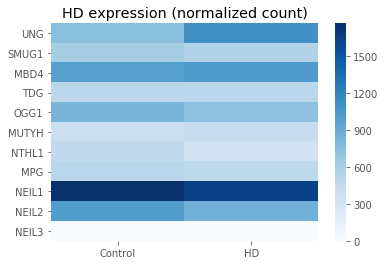

In [184]:
for k,v in hd_sample_dic.items():
    hd_pivot_df[k] = hd_pivot_df[v].median(axis=1)
ax = sns.heatmap(hd_pivot_df.loc[interest_genes, hd_sample_dic.keys()], cmap='Blues')
_ = ax.set_title('HD expression (normalized count)')
_ = ax.set_ylabel('')

In [185]:
# box_plot(3, (10, 80), hd_nm_df, interest_genes, 'Diagnosis')

In [186]:
# for g in interest_genes:
#     g_df = hd_nm_df[['Diagnosis',g]]
    
#     ax = g_df.boxplot(by='Diagnosis',grid=True)
#     figs = ax.get_figure()
#     figs.suptitle('')
#     ax.set_title(g + ' (HD)')
#     ax.set_xlabel('')
#     ax.set_ylabel('tpm')
#     plt.savefig('/home/lis262/RE/HD_BA9/'+ g + '.png')

### Now let's merge all the data into one dataframe

In [187]:
int_gtx_pivot_df = gtx_tpm_med_df.loc[interest_genes,:]
# LIBER data
int_liber_pivot_df = liber_int_pivot_df.loc[interest_genes, ['Bipolar','Control','MDD','Schizo']]
int_liber_pivot_df = int_liber_pivot_df.rename(index=str,columns={'Bipolar':'LIBER_Biopolar','Control':'LIBER_Control',
                                                                 'MDD':'LIBER_MDD', 'Schizo':'LIBER_Schizo'})
# HD data
hd_pivot_df = hd_pivot_df.rename(index=str, columns={'Control':'HD_control'})
int_hd_pivot_df = hd_pivot_df.loc[interest_genes, ['HD_control', 'HD']]
# cerebellum
int_cerebellum_pivot_df = cerebellum_pivot_df.loc[interest_genes, ['AD','Control']]
int_cerebellum_pivot_df = int_cerebellum_pivot_df.rename(index=str, columns={'AD':'Cereb_AD','Control':'Cereb_Control'})
# cortex
int_cortex_pivot_df = cortex_pivot_df.loc[interest_genes, ['AD','Control']]
int_cortex_pivot_df = int_cortex_pivot_df.rename(index=str, columns={'AD':'Cortex_AD','Control':'Cortex_Control'})
# merge
int_final_df = pd.concat([int_gtx_pivot_df, int_liber_pivot_df, int_hd_pivot_df,
                         int_cerebellum_pivot_df, int_cortex_pivot_df], axis=1)
# output to file
int_final_df.to_csv('~/data.csv', sep='\t',)